In [1]:

import tifffile as tf
import zarr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
import zarr
from scipy.spatial import KDTree
import tifffile as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.array as da

In [2]:


# Paths to data
csv_path = "/Users/swarchol/Research/exemplar-001/quantification/exemplar-001--unmicst_cell.csv"
segmentation_path = "/Users/swarchol/Research/exemplar-001/segmentation/unmicst-exemplar-001/nuclei.ome.tif"
image_path = "/Users/swarchol/Research/exemplar-001/registration/exemplar-001.ome.tif"
# zarr_path = "/Users/swarchol/Research/exemplar-001/cellcutter/cut_mask"
zarr_path = "/Users/swarchol/Research/exemplar-001/cellcutter/cut"
cells = zarr.open(zarr_path)
# Load data
csv_df = pd.read_csv(csv_path)
tree = KDTree(csv_df[['X_centroid', 'Y_centroid']].values)


def get_shapes(image_path):
    with tf.TiffFile(image_path, is_ome=False) as img_io:
        img = zarr.open(img_io.series[0].aszarr())
        shapes = [img[i].shape for i in range(len(img))]
    return shapes

def get_points_in_rect(kdtree, rect_points):
    center = np.mean(rect_points, axis=1)
    y_range, x_range = rect_points
    x_range = np.sort(x_range)
    y_range = np.sort(y_range)
    nearest_neighbor = kdtree.query(center, k=1)[1]
    nearest_neighbor_location = kdtree.data[nearest_neighbor].flatten()
    # Check if in y range
    if (
        nearest_neighbor_location[1] < x_range[0]
        or nearest_neighbor_location[1] > x_range[1]
    ):
        return None
    if (
        nearest_neighbor_location[0] < y_range[0]
        or nearest_neighbor_location[0] > y_range[1]
    ):
        return None

    return nearest_neighbor

In [24]:


def get_tile(c, z, x, y, tree, cut_cells, tile_size=np.array([1024,1024])):
    shapes = get_shapes(image_path)
    pyramid_level_shape = shapes[z][-2:]
    # If pyramid level is smaller than tile size, adjust tile size
    
    print('tile size', tile_size)
    # These are in embedding space
    
    # Adjust tile size if it exceeds the pyramid level dimensions
    tile_height = min(tile_size[0], pyramid_level_shape[0])
    tile_width = min(tile_size[1], pyramid_level_shape[1])
    # Tile range in the pyramid level
    if x * tile_size[1] >= pyramid_level_shape[1] or y * tile_size[0] >= pyramid_level_shape[0]:
        return None
    if (x + 1) * tile_size[1] >= pyramid_level_shape[1]:
        tile_width = pyramid_level_shape[1] - x * tile_size[1]
    if (y + 1) * tile_size[0] >= pyramid_level_shape[0]:
        tile_height = pyramid_level_shape[0] - y * tile_size[0]

    tile = np.zeros((tile_height, tile_width), dtype=np.uint16)
    print('Shape',cut_cells.shape)
    x_tiles = tile_width // cut_cells.shape[-1]
    y_tiles = tile_height // cut_cells.shape[-1]
    test_points = []

    tile_start_y = y * (2**z) * tile_size[0]
    tile_start_x = x * (2**z) * tile_size[1]

    for i in tqdm(range(x_tiles)):
        for j in range(y_tiles):
            
            image_y_range = [
                tile_start_x + int((i / x_tiles) * tile_width * (2**z)),
                tile_start_x + int(((i + 1) / x_tiles) * tile_width * (2**z)),
            ]
            image_x_range = [
                tile_start_y + int((j / y_tiles) * tile_height * (2**z)),
                tile_start_y + int(((j + 1) / y_tiles) * tile_height * (2**z)),
            ]

            # Ensure ranges do not exceed the pyramid level dimensions
            # if range is outside of the image, skip
            if image_x_range[0] >= shapes[0][-2] or image_y_range[0] >= shapes[0][-1]:
                continue
            point = get_points_in_rect(tree, [image_y_range, image_x_range])
            if point is not None:
                sub_tile_x_range = [
                    int((i / x_tiles) * tile_width),
                    int(((i + 1) / x_tiles) * tile_width),
                ]
                sub_tile_y_range = [
                    int((j / y_tiles) * tile_height),
                    int(((j + 1) / y_tiles) * tile_height),
                ]
                test_points.append(point)
                data = cut_cells[c,point]                
                tile[
                    sub_tile_y_range[0] : sub_tile_y_range[0] + data.shape[0],
                    sub_tile_x_range[0] : sub_tile_x_range[0] + data.shape[1],
                ] = data

    return np.ascontiguousarray(tile)


tile size [1024 1024]
Shape (12, 11170, 39, 39)


100%|██████████| 26/26 [00:05<00:00,  5.19it/s]


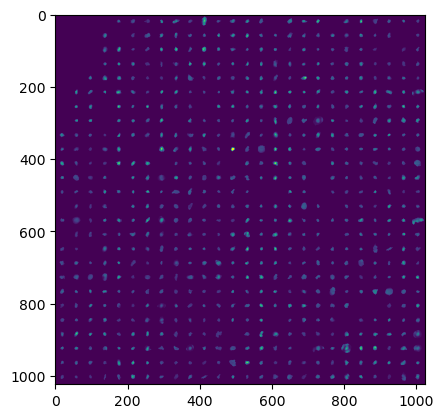

In [25]:
# Display the tile

test_tile = np.array(get_tile(c=0, z=0, x=0, y=1, tree=tree, cut_cells=cells))
# plt.scatter(tree.data[:, 0], tree.data[:, 1], color="red")
# plt.scatter(test_tile[:, 0], test_tile[:, 1])

plt.imshow(test_tile)


In [5]:
test_points

NameError: name 'test_points' is not defined

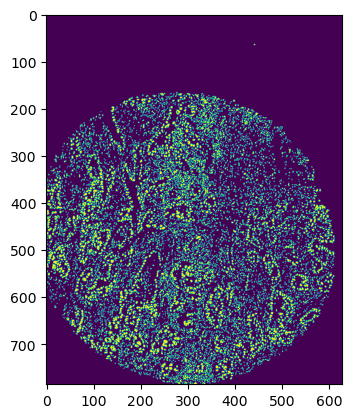

In [ ]:
seg = tf.TiffFile(segmentation_path, is_ome=False)
seg_zarr = zarr.open(seg.series[0].aszarr())

seg_zarr
# plt.imshow(seg.asarray(series=0)[0])    
binary_mark = np.array(seg_zarr[2])
# set all values over 0 to 1
binary_mark[binary_mark > 0] = 1
plt.imshow(binary_mark)

In [ ]:
shapes

NameError: name 'shapes' is not defined

In [ ]:
get_shapes(segmentation_path)

[(3139, 2511), (1570, 1256), (785, 628)]

In [ ]:
3139/1024, 2511/1024


(3.0654296875, 2.4521484375)

NameError: name 'all_cells_combined' is not defined

[(27120, 26139),
 (13560, 13070),
 (6780, 6535),
 (3390, 3268),
 (1695, 1634),
 (848, 817)]

In [ ]:
zarr_path = "/Users/swarchol/Research/bed/data/channel_39_mask"
seg = zarr.open(zarr_path)
seg

<zarr.core.Array (1242756, 75, 75) bool>

In [ ]:
image_io = tf.TiffFile("/Users/swarchol/Research/exemplar-001/registration/exemplar-001.ome.tif", is_ome=False)
image_zarr = zarr.open(image_io.series[0].aszarr())

In [ ]:
z=0
x=0
y=0
c=0
tile_size = 1024
pyramid_level_shape = image_zarr[z].shape
z =     len(image_zarr) - z - 1
tile_indices = [x*tile_size, (x+1)*tile_size], [y*tile_size, (y+1)*tile_size]
print(tile_indices)
# Make sure indices are within the image
tile_indices[0][1] = min(tile_indices[0][1], pyramid_level_shape[z])
tile_indices[1][1] = min(tile_indices[1][1], pyramid_level_shape[z])
tile = image_zarr[z][c][tile_indices[1][0]:tile_indices[1][1], tile_indices[0][0]:tile_indices[0][1]]
# 
tile.shape
tile_indices

([0, 1024], [0, 1024])


([0, 1024], [0, 1024])

In [ ]:
[image_zarr[i].shape for i in range(len(image_zarr))]

[(12, 3139, 2511), (12, 1570, 1256), (12, 785, 628)]

In [ ]:
pyramid_level_shape[z]

2511

In [ ]:
def get_shapes(segmentation_path):
    seg_io = tf.TiffFile(segmentation_path, is_ome=False)
    seg = zarr.open(seg_io.series[0].aszarr())
    shapes = [seg[i].shape for i in range(len(seg))]
    return shapes
shapes = get_shapes('/Users/swarchol/Research/exemplar-001/segmentation/unmicst-exemplar-001/nuclei.ome.tif')
shapes

[(3139, 2511), (1570, 1256), (785, 628)]

In [ ]:
shapes = get_shapes('/Users/swarchol/Research/exemplar-001/registration/exemplar-001.ome.tif')
shapes


[(12, 3139, 2511), (12, 1570, 1256), (12, 785, 628)]

In [ ]:
pd.read_csv('/Users/swarchol/Research/exemplar-001/quantification/exemplar-001--unmicst_cell.csv')

,CellID,DNA_6,ELANE,CD57,CD45,DNA_7,CD11B,SMA,CD16,DNA_8,...,NCAM,X_centroid,Y_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Solidity,Extent,Orientation
0,1,17597.443478,1176.791304,160.782609,703.991304,5866.643478,377.400000,245.260870,331.278261,6816.017391,...,853.147826,1768.330435,257.226087,115,12.375868,11.823117,0.295521,0.966387,0.798611,-1.104797
1,2,18031.086957,1125.282609,176.934783,792.826087,11817.923913,910.304348,422.347826,646.923913,13424.717391,...,902.489130,1107.173913,665.869565,92,11.874070,9.982065,0.541562,0.948454,0.696970,-0.435290
2,3,8402.596774,1249.532258,156.951613,816.225806,5040.790323,1046.177419,487.854839,601.790323,5557.935484,...,940.209677,1116.290323,671.338710,62,9.995049,8.673949,0.496871,0.837838,0.563636,1.355995
3,4,22322.404412,1156.683824,187.330882,853.250000,13716.878676,816.955882,2187.911765,376.194853,15479.356618,...,892.334559,982.845588,676.996324,272,25.566077,15.136434,0.805900,0.834356,0.537549,-0.709765
4,5,8101.017199,1570.628993,163.009828,318.027027,4959.896806,826.963145,361.771499,366.088452,5628.589681,...,896.872236,1141.135135,680.140049,407,26.723557,19.630426,0.678529,0.933486,0.707826,-0.719601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11165,11166,14693.016949,1224.372881,208.853107,1071.937853,8231.203390,865.022599,1187.045198,379.988701,10322.225989,...,890.841808,1260.186441,3132.457627,177,20.959097,11.374283,0.839933,0.917098,0.702381,-1.390099
11166,11167,23067.893939,1217.439394,228.727273,1247.242424,13142.106061,775.621212,1038.151515,367.500000,12688.318182,...,880.242424,1156.121212,3131.393939,66,10.461985,8.316377,0.606722,0.891892,0.660000,-0.387542
11167,11168,24690.942029,1173.768116,206.217391,973.942029,14485.637681,706.695652,1816.202899,353.681159,17806.826087,...,956.217391,1175.463768,3132.014493,69,11.165588,7.978289,0.699592,0.920000,0.766667,0.774327
11168,11169,21059.903226,1159.645161,224.365591,1073.870968,12691.688172,745.096774,1143.000000,364.215054,15388.989247,...,879.677419,1274.462366,3132.591398,93,11.701692,10.342006,0.467857,0.939394,0.845455,-1.296469


In [3]:
cells.shape

(40, 1242756, 75, 75)

In [ ]:
zarr_path = "/Users/swarchol/Research/bed/data/for_simon/combined.zarr"
cells = zarr.open(zarr_path)
z1 = zarr.open('/Users/swarchol/Research/bed/data/for_simon/rechunked_combined.zarr', mode='w', shape=(40, 1242756, 75, 75), chunks=(40, 1, 75, 75), dtype='uint16')
for i in tqdm(range(1242756 // 5000 )):
    i_start = i * cells.chunks[0]
    i_end = min((i + 1) * 5000, 1242756)
    these_cells = cells[:,i_start:i_end,:,:] 
    z1[:,i_start:i_end,:,:] = these_cells
    these_cells = None
    

  8%|▊         | 10/124 [18:13<5:18:28, 167.62s/it]

: 

In [23]:
cells.shape

(12, 11170, 39, 39)

In [10]:
for i in tqdm(range(40)):
    z1[i,:,:,:] = cells[i,:,:,:]

  0%|          | 0/40 [03:49<?, ?it/s]


KeyboardInterrupt: 

In [6]:
store = zarr.DirectoryStore('/Users/swarchol/Research/bed/data/for_simon/rechunked_combined.zarr')
store = zarr.zeros

In [1]:

import tifffile as tf
import zarr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
import zarr
from scipy.spatial import KDTree
import tifffile as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.array as da

In [2]:
image_path = "/Users/swarchol/Downloads/full_downsampled_wi.tif"


In [4]:
image = tf.TiffFile(image_path, is_ome=False)
image_zarr = zarr.open(image.series[0].aszarr())

In [5]:
image_zarr


<zarr.core.Array (6, 16128, 13440) uint8>

In [ ]:
def convertOmeTiff(filePath, channelFilePath=None, dataDirectory=None, isLabelImg=False):
    channel_info = {}
    channelNames = []
    if isLabelImg == False:
        channel_io = tf.TiffFile(str(filePath), is_ome=False)
        channels = zarr.open(channel_io.series[0].aszarr())
        if isinstance(channels, zarr.Array):
            print(1)
            channel_info['maxLevel'] = 1
            chunks = channels.chunks
            if chunks[1] == 1 or chunks[2] == 1:
                chunks = [1, channels.shape[1], channels.shape[2]]
                channel_info['channels'] = channels.shape[0]
            shape = channels.shape
        else:
            print(2)

        print(channels)